In [1]:
%cd DA_DFD

/data/home/jkataok1/DA_DFD


In [2]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from glob import glob
import os
import scipy.io
from sklearn.linear_model import LogisticRegression
from scipy.signal import spectrogram
import torch.nn as nn
import torch
from collections import OrderedDict
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.utils.data as Data
import wandb

sys.path.append("/data/home/jkataok1/DA_DFD")

from src.dataloader import generate_dataset
from src.ast_models import ASTModel
from src.helper import count_batch_on_large_dataset

/data/home/jkataok1/mlenv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [79]:
model = ASTModel(label_dim=4, input_tdim=65, input_fdim=18, imagenet_pretrain=False, audioset_pretrain=False)
model_simclr = ASTModel(label_dim=4, input_tdim=65, input_fdim=18, imagenet_pretrain=False, audioset_pretrain=False)
checkpoint = "/data/home/jkataok1/DA_DFD/src_models/CWRU_all_spectrogram_IMS_0_spectrogram_src_ast.pth"

state_dict_temp = torch.load(checkpoint)
model_params = model.state_dict()
for name, param in state_dict_temp.items():
    if name in model_params:
        model_params[name].copy_(param)
        print("copy {}".format(name), sep="\r")
    else:
        print("skip {}".format(name), sep="\r")
model.load_state_dict(state_dict_temp, strict=True)
model_simclr.load_state_dict(state_dict_temp, strict=True)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        # add mlp projection head
        embedding_size = 1024

        mlp_dim= model.mlp_head[-1].in_features
        self.projection = nn.Sequential(
           nn.Linear(in_features=mlp_dim, out_features=mlp_dim),
           nn.BatchNorm1d(mlp_dim),
           nn.ReLU(),
           nn.Linear(in_features=mlp_dim, out_features=embedding_size),
           nn.BatchNorm1d(embedding_size))

    def forward(self, x):
        x = self.projection(x)

        return x

model_simclr.mlp_head = Identity()
model.mlp_head=Identity()
model = model.to("cuda")
model_simclr = model_simclr.to("cuda")
simCLR_checkpoint = torch.load('/data/home/jkataok1/DA_DFD/log/SimCLR_01/SimCLR.pth')
model_simclr.load_state_dict(simCLR_checkpoint)

---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=5
---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=5
copy v.cls_token
copy v.pos_embed
copy v.dist_token
copy v.patch_embed.proj.weight
copy v.patch_embed.proj.bias
copy v.blocks.0.norm1.weight
copy v.blocks.0.norm1.bias
copy v.blocks.0.attn.qkv.weight
copy v.blocks.0.attn.qkv.bias
copy v.blocks.0.attn.proj.weight
copy v.blocks.0.attn.proj.bias
copy v.blocks.0.norm2.weight
copy v.blocks.0.norm2.bias
copy v.blocks.0.mlp.fc1.weight
copy v.blocks.0.mlp.fc1.bias
copy v.blocks.0.mlp.fc2.weight
copy v.blocks.0.mlp.fc2.bias
copy v.blocks.1.norm1.weight
copy v.blocks.1.norm1.bias
copy v.blocks.1.attn.qkv.weight
copy v.blocks.1.attn.qkv.bias
copy v.blocks.1.attn.proj.weight
copy v.blocks.1.attn.proj.bias
copy v.blocks.1.norm2.weig

<All keys matched successfully>

In [80]:
batch_size = 128*2  # Set the batch size that fits into your GPU
epochs = 1

src_dataset, tar_dataset = generate_dataset("/data/home/jkataok1/DA_DFD/data/processed",
                    "CWRU", "IMS", "all_spectrogram", "0_spectrogram")
src_dataloader = Data.DataLoader(src_dataset, 
                                    batch_size=batch_size, shuffle=False, drop_last=False)
tar_dataloader = Data.DataLoader(tar_dataset,
                                    batch_size=batch_size, shuffle=False, drop_last=False) 


In [81]:
def get_feature(model, src_dataloader):
    model.eval()
    src_z_list = []
    src_label_list = []

    for i, (src_idx, src_input, src_target) in enumerate(src_dataloader):
        src_input = src_input.cuda()
        src_z = model(src_input)
        src_z_list.append(src_z.detach().cpu().numpy())
        src_label_list.append(src_target.detach().cpu().numpy())

    src_z_list = np.concatenate(src_z_list, axis=0)
    src_label_list = np.concatenate(src_label_list, axis=0)

    return src_z_list, src_label_list

In [82]:
src_feature, src_label = get_feature(model, src_dataloader)
tar_feature, tar_label = get_feature(model, tar_dataloader)

simclr_src_feature, simclr_src_label = get_feature(model_simclr, src_dataloader)
simclr_tar_feature, simclr_tar_label = get_feature(model_simclr, tar_dataloader)

In [83]:
tsne = TSNE(n_components=2, random_state=0)
z = np.concatenate([src_feature, tar_feature], axis=0)
simclr_z = np.concatenate([simclr_src_feature, simclr_tar_feature], axis=0)
tsne_all = tsne.fit_transform(all_z)
tsne_simclr = tsne.fit_transform(simclr_z)
tsne_src_z = tsne_all[:src_z_list.shape[0]]
tsne_tar_z = tsne_all[src_z_list.shape[0]:]
tsne_src_simclr_z = tsne_simclr[:src_z_list.shape[0]]
tsne_tar_simclr_z = tsne_simclr[src_z_list.shape[0]:]
#src_z_list.shape, tar_z_list.shape

NameError: name 'src_simclr_z_list' is not defined

In [50]:
def get_colmap(y, color_list):
    colmap = []
    for i in y:
        colmap.append(color_list[int(i)])
    return colmap


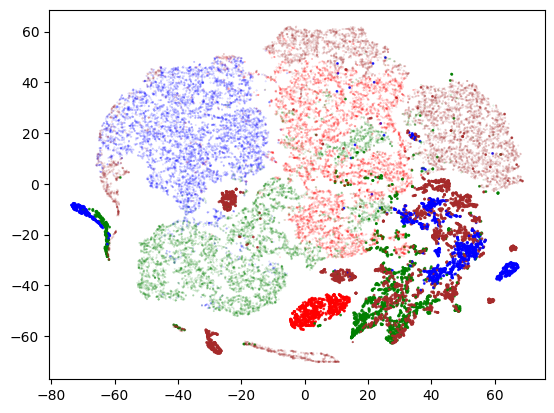

In [55]:
plt.scatter(tsne_src_z[:, 0], tsne_src_z[:, 1], c=get_colmap(src_label_list, ["red", "green", "blue", "brown"]), alpha=0.8, label='cwru', s=1)
plt.scatter(tsne_tar_z[:, 0], tsne_tar_z[:, 1], c=get_colmap(tar_label_list, ["red", "green", "blue", "brown"]), alpha=0.2, label='cwru', s=0.1)